In [1]:
from typing import Any, OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import transforms as T
from torchvision.models.resnet import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

from torchmetrics import Accuracy

import pytorch_lightning as L
from pytorch_lightning.utilities.types import STEP_OUTPUT

from wilds import get_dataset
from wilds.common.data_loaders import get_eval_loader, get_train_loader
from wilds.common.grouper import CombinatorialGrouper

from tqdm import tqdm

In [2]:
def get_backbone_from_ckpt(ckpt_path: str) -> torch.nn.Module:
    state_dict = torch.load(ckpt_path)["state_dict"]
    state_dict = OrderedDict([
        (".".join(name.split(".")[1:]), param) for name, param in state_dict.items() if name.startswith("backbone")
    ])

    return state_dict

In [4]:
model = resnet50(num_classes=2)
model.load_state_dict(get_backbone_from_ckpt("../data/epoch=25-step=45050.ckpt"), strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [5]:
class ResNet50(nn.Module):
    def __init__(self, num_classes=2, pretrain=None) -> None:
        super().__init__()

        print(f"Pretrain: {pretrain}")

        if pretrain == "imagenet":
            self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
            self.model.fc = nn.Linear(2048, num_classes)

        elif pretrain == "bt":  
            self.model = resnet50(num_classes=num_classes)
            missing_keys, unexpected_keys = self.model.load_state_dict(get_backbone_from_ckpt("../data/epoch=25-step=45050.ckpt"), strict=False)

        elif pretrain == "bt_disc":
            self.model = resnet50(num_classes=num_classes)
            missing_keys, unexpected_keys = self.model.load_state_dict(get_backbone_from_ckpt("../data/epoch=27-step=47966.ckpt"), strict=False)

        elif pretrain == None:
            self.model = resnet50(num_classes=num_classes)
  
        else:
            raise Exception("Invalid pretrain!")
            
    def forward(self, x: torch.Tensor):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.model.fc(x)

        return x
    
    def embed(self, x: torch.Tensor):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        z0 = x.mean(dim=[2,3])

        x = self.model.layer1(x)
        z1 = x.mean(dim=[2,3])

        x = self.model.layer2(x)
        z2 = x.mean(dim=[2,3])
        
        x = self.model.layer3(x)
        z3 = x.mean(dim=[2,3])
        
        x = self.model.layer4(x)
        z4 = x.mean(dim=[2,3])

        x = self.model.avgpool(x).squeeze()
    
        return {
            "z0": z0,
            "z1": z1,
            "z2": z2,
            "z3": z3,
            "z4": z4,
            "x": x
        }

In [6]:
transform = T.Compose([
    T.ToTensor()
])

In [7]:
class SimpleCNN(L.LightningModule):
    def __init__(self, in_channels=3, num_cls=2, pretrain=None, freeze=False, *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)


        # self.model = CNN(in_channels=in_channels, num_classes=num_cls)
        self.model = ResNet50(num_classes=num_cls, pretrain=pretrain)

        self.criterion = torch.nn.CrossEntropyLoss()

        if freeze:
            params=[]
            params += list(self.model.model.fc.parameters())
            params += list(self.model.model.layer4.parameters())
        else:
            params=self.parameters()

        self.optimizer = torch.optim.SGD(params=params, lr=1e-3, weight_decay=1e-2, momentum=0.9)
        self.metric = Accuracy(num_classes=2, task='multiclass')

    def training_step(self, batch, batch_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X)
        loss = self.criterion(y, t)

        self.log("loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx, dataloader_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X).argmax(dim=1)
        
        accuracy = self.metric(y, t)

        if dataloader_idx == 0:
            self.log('id_accuracy', accuracy)
        elif dataloader_idx == 1:
            self.log('ood_accuracy', accuracy)

        return accuracy
    
    def test_step(self, batch, batch_idx, dataloader_idx) -> STEP_OUTPUT:
        X, t, _ = batch

        y = self.model(X).argmax(dim=1)
        
        accuracy = self.metric(y, t)

        if dataloader_idx == 0:
            self.log('test/id_accuracy', accuracy)
        elif dataloader_idx == 1:
            self.log('test/ood_accuracy', accuracy)

        return accuracy
    
    def configure_optimizers(self) -> Any:
        return self.optimizer

In [9]:
dataset = get_dataset("camelyon17", root_dir="../../data/")
train_set = dataset.get_subset("train", transform=transform)
val_set = dataset.get_subset("id_val", transform=transform)
val_set_s = dataset.get_subset("id_val", transform=transform, frac=1/3)
test_set = dataset.get_subset('test', transform=transform)
test_set_s = dataset.get_subset('test', transform=transform, frac=1/10)

grouper = CombinatorialGrouper(dataset, ['hospital'])

train_loader = get_train_loader("standard", train_set, grouper=grouper,uniform_over_groups=True, batch_size=32, num_workers=8)
val_loader = get_eval_loader('standard', val_set, batch_size=64, num_workers=8)
test_loader = get_eval_loader('standard', test_set, batch_size=64, num_workers=8)

val_loader_s = get_eval_loader('standard', val_set_s, batch_size=64, num_workers=8)
test_loader_s = get_eval_loader('standard', test_set_s, batch_size=64, num_workers=8)

In [10]:
trainer = L.Trainer(
    accelerator="auto", 
    max_epochs=10, 
    val_check_interval=int(len(train_loader)/3),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
model_scr = SimpleCNN(in_channels=3, num_cls=2)
trainer.fit(
    model_scr,
    train_dataloaders=train_loader,
    val_dataloaders=[val_loader_s, test_loader_s],
    # ckpt_path='lightning_logs/version_21/checkpoints/epoch=1-step=18902.ckpt'
)

Pretrain: None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet50           | 23.5 M
1 | criterion | CrossEntropyLoss   | 0     
2 | metric    | MulticlassAccuracy | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/yasin/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [13]:
trainer.test(
    model=model_scr,
    dataloaders=[val_loader, test_loader],
    ckpt_path='lightning_logs/version_18/checkpoints/epoch=5-step=56710.ckpt'
)

Restoring states from the checkpoint path at lightning_logs/version_18/checkpoints/epoch=5-step=56710.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at lightning_logs/version_18/checkpoints/epoch=5-step=56710.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/id_accuracy      │    0.7099820971488953     │                           │
│     test/ood_accuracy     │                           │    0.6683166027069092     │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/id_accuracy/dataloader_idx_0': 0.7099820971488953},
 {'test/ood_accuracy/dataloader_idx_1': 0.6683166027069092}]

In [16]:
BS = 64

In [17]:
grouper = CombinatorialGrouper(dataset, ['hospital'])

In [18]:
source_set = dataset.get_subset("train", transform=transform, frac=10_000/len(train_set))
target_set = dataset.get_subset("test", transform=transform, frac=10_000/len(test_set))

source_loader = get_eval_loader("standard", source_set, batch_size=BS, num_workers=8, grouper=grouper)
target_loader = get_eval_loader("standard", target_set, batch_size=BS, num_workers=8, grouper=grouper)

### Plot every layer

In [19]:
results = {}

In [20]:
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [21]:
def plot_layer(ax, source: torch.Tensor, target: torch.Tensor, layer='x', acc: float=0.0):
    reducer = umap.UMAP(n_neighbors=5, n_epochs=1000, min_dist=0.1)
    all_embeddings = torch.cat([source[layer], target[layer]],dim=0)
    all_targets = torch.cat([source['t'], target['t']], dim=0)
    
    X_scaled = StandardScaler().fit_transform(all_embeddings)

    reducer = umap.UMAP(n_neighbors=5, min_dist=0.07)
    X_reduced = reducer.fit_transform(X_scaled)

    source_target = torch.cat([torch.zeros(10_000), torch.ones(10_000)])

    color_values = torch.cat([source_target[None,:], all_targets[None,:]], dim=0)

    color_map = {
        (0,0): "royalblue", # source, no_tumor
        (0,1): "mediumaquamarine", # source, tumor
        (1,0): "gold", # target, no_tumor
        (1,1): "goldenrod" # target, tumor
    }

    colors_master = [color_map[tuple(x.to(int).tolist())] for x in color_values.T]

    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        c=colors_master,
        s=0.05
    )
    ax.set_xlabel(f"Layer: {layer}\n Accuracy: {acc}")


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [42]:
def predict_domain(source, target, layer='x', C=0.1):
    X = torch.cat([source[layer], target[layer]], dim=0)
    t = torch.cat([source['d'], target['d']], dim=0)

    X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('lor', LogisticRegression(max_iter=2000, C=C))
    ])

    pipe.fit(X_train, t_train)
    # print(classification_report(t_test, pipe.predict(X_test)))

    return accuracy_score(t_test, pipe.predict(X_test))

In [43]:
def compute_embeddings(model: nn.Module, source_loader, target_loader):
    num_samples_source = source_loader.dataset.__len__()
    num_samples_target = target_loader.dataset.__len__()

    source = {
        'z0': torch.empty((num_samples_source, 64)),
        'z1': torch.empty((num_samples_source, 256)),
        'z2': torch.empty((num_samples_source, 512)),
        'z3': torch.empty((num_samples_source, 1024)),
        'z4': torch.empty((num_samples_source, 2048)),
        'x': torch.empty((num_samples_source, 2048)),
        't': torch.empty((num_samples_source)),
        'd': torch.empty((num_samples_source)),
    }
    target = {
        'z0': torch.empty((num_samples_target, 64)),
        'z1': torch.empty((num_samples_target, 256)),
        'z2': torch.empty((num_samples_target, 512)),
        'z3': torch.empty((num_samples_target, 1024)),
        'z4': torch.empty((num_samples_target, 2048)),
        'x': torch.empty((num_samples_target, 2048)),
        't': torch.empty((num_samples_target)),
        'd': torch.empty((num_samples_target)),
    }

    with torch.no_grad():
        for i, (X, t, M) in enumerate(tqdm(source_loader)):
            bs = len(X)

            d = grouper.metadata_to_group(M)

            embs = model.embed(X.cuda())
            source['z0'][i*BS:i*BS+bs] = embs['z0'].cpu()
            source['z1'][i*BS:i*BS+bs] = embs['z1'].cpu()
            source['z2'][i*BS:i*BS+bs] = embs['z2'].cpu()
            source['z3'][i*BS:i*BS+bs] = embs['z3'].cpu()
            source['z4'][i*BS:i*BS+bs] = embs['z4'].cpu()
            source['x'][i*BS:i*BS+bs] = embs['x'].cpu()
            source['t'][i*BS:i*BS+bs] = t
            source['d'][i*BS:i*BS+bs] = d

        for i, (X, t, M) in enumerate(tqdm(target_loader)):
            bs = len(X)

            d = grouper.metadata_to_group(M)

            embs = model.embed(X.cuda())
            target['z0'][i*BS:i*BS+bs] = embs['z0'].cpu()
            target['z1'][i*BS:i*BS+bs] = embs['z1'].cpu()
            target['z2'][i*BS:i*BS+bs] = embs['z2'].cpu()
            target['z3'][i*BS:i*BS+bs] = embs['z3'].cpu()
            target['z4'][i*BS:i*BS+bs] = embs['z4'].cpu()
            target['x'][i*BS:i*BS+bs] = embs['x'].cpu()
            target['t'][i*BS:i*BS+bs] = t
            target['d'][i*BS:i*BS+bs] = d

    return source, target

In [44]:
def evaluate(model: nn.Module, source_loader, target_loader, name: str, C=[0.1, 0.1, 0.1, 0.1, 0.1]):
    source, target = compute_embeddings(model, source_loader, target_loader)

    # Compute domain accuracy
    print('PD@0')
    acc_l0 = predict_domain(source, target, 'z0', C=C[0])
    print('PD@1')
    acc_l1 = predict_domain(source, target, 'z1', C=C[1])
    print('PD@2')
    acc_l2 = predict_domain(source, target, 'z2', C=C[2])
    print('PD@3')
    acc_l3 = predict_domain(source, target, 'z3', C=C[3])
    print('PD@4')
    acc_l4 = predict_domain(source, target, 'z4', C=C[4])
    print('----------')

    results[name] = [acc_l0, acc_l1, acc_l2, acc_l3, acc_l4]

    # Plot embeddings
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5)

    fig.set_figheight(3)
    fig.set_figwidth(18)

    plot_layer(ax0, source, target, layer='z0', acc=acc_l0)
    plot_layer(ax1, source, target, layer='z1', acc=acc_l1)
    plot_layer(ax2, source, target, layer='z2', acc=acc_l2)
    plot_layer(ax3, source, target, layer='z3', acc=acc_l3)
    plot_layer(ax4, source, target, layer='z4', acc=acc_l4)

100%|██████████| 157/157 [00:04<00:00, 32.59it/s]


PD@0
PD@1
PD@2
PD@3
PD@4
----------


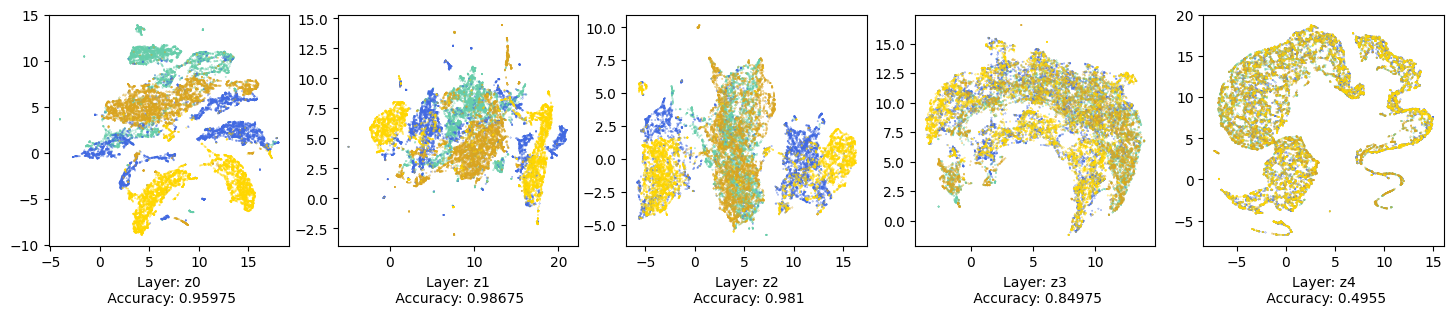

In [45]:
model_ = model_scr.model.cuda()
evaluate(model_, source_loader, target_loader, name="scratch", C=[0.1, 0.1, 0.1, 0.1, 0.1])

Pretrain: imagenet


100%|██████████| 157/157 [00:04<00:00, 32.05it/s]


PD@0
PD@1
PD@2
PD@3
PD@4
----------


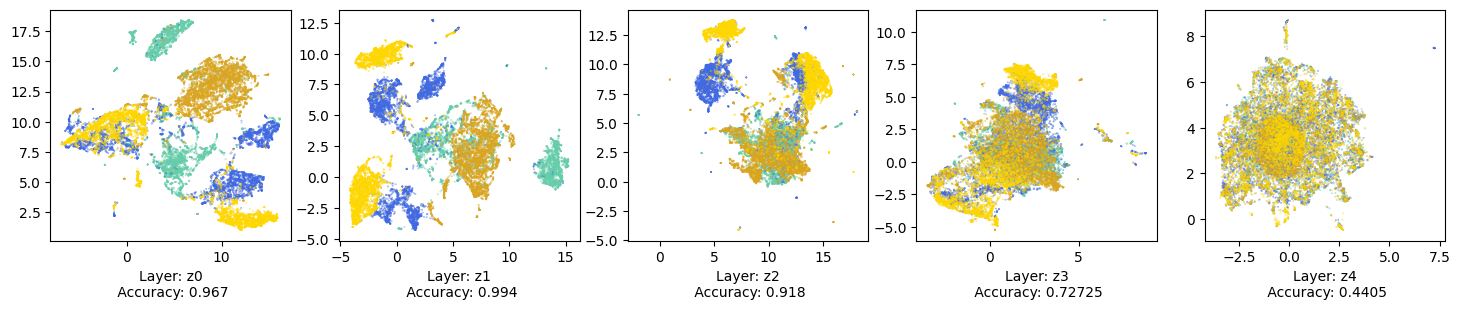

In [46]:
model = SimpleCNN(in_channels=3, num_cls=2, pretrain='imagenet')
model_ = model.model.cuda()
evaluate(model_, source_loader, target_loader, name="imagenet")

Pretrain: bt


100%|██████████| 157/157 [00:04<00:00, 31.75it/s]


PD@0
PD@1
PD@2
PD@3
PD@4
----------


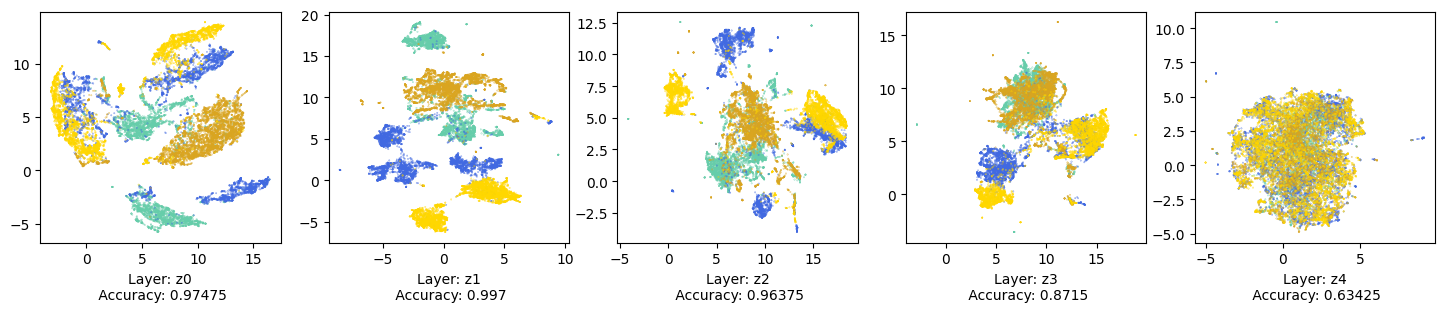

In [47]:
model = SimpleCNN(in_channels=3, num_cls=2, pretrain="bt", freeze=True)
model_ = model.model.cuda()
evaluate(model_, source_loader, target_loader, name="barlowtwins")

Pretrain: bt_disc


100%|██████████| 157/157 [00:04<00:00, 31.60it/s]


PD@0
PD@1
PD@2
PD@3
PD@4
----------


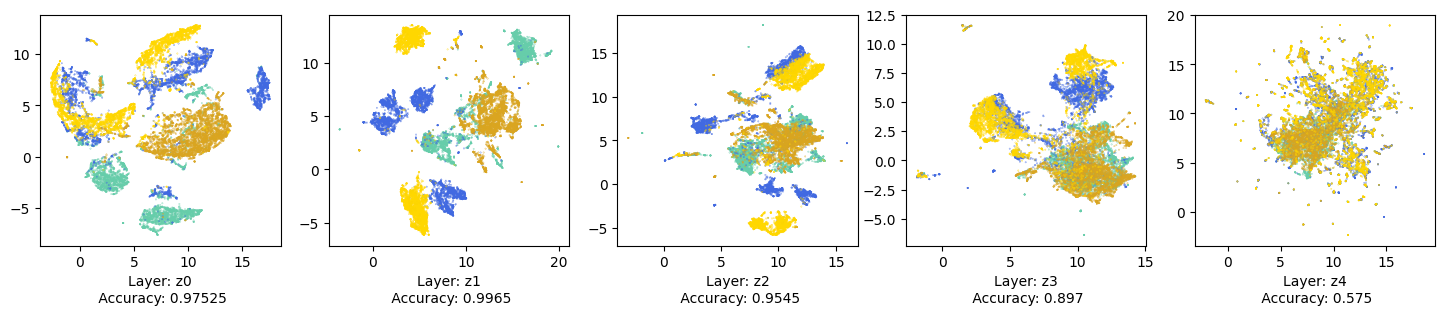

In [48]:
model = model = SimpleCNN(in_channels=3, num_cls=2, pretrain="bt_disc")
model_ = model.model.cuda()
evaluate(model_, source_loader, target_loader, name='bt+disc')

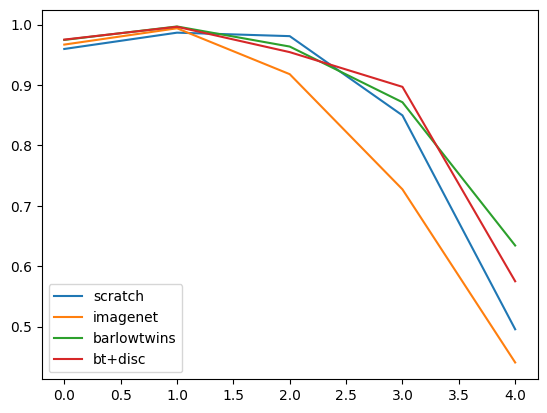

In [49]:
for name, vals in results.items():
    plt.plot(vals, label=name)
plt.legend()